In [7]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [8]:
class Node:
    """Helper class to store RRT graph nodes"""
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None

def create_grid_with_obstacles(n, k, m):
    """
    Generates an n x n grid with k random obstacles of size m x m.
    0 = Free, 1 = Obstacle
    """
    # 1. Create empty grid filled with 0s
    grid = np.zeros((n, n))

    # 2. Place k random obstacles
    for _ in range(k):
        # Choose random position (ensure block fits within grid)
        r_x = random.randint(0, n - m)
        r_y = random.randint(0, n - m)

        # Mark block as occupied (1)
        grid[r_y:r_y+m, r_x:r_x+m] = 1

    return grid

def check_collision(x, y, grid, robot_size=2):
    """
    Checks if the robot (represented by 4 corner points) collides with an obstacle.
    Returns True if collision detected, False otherwise.
    """
    rows, cols = grid.shape

    # Define the 4 corner points relative to (x, y)
    # Assuming (x,y) is top-left. You can adjust offset if (x,y) is center.
    corners = [
        (int(x), int(y)),                       # Top-Left
        (int(x + robot_size), int(y)),          # Top-Right
        (int(x), int(y + robot_size)),          # Bottom-Left
        (int(x + robot_size), int(y + robot_size)) # Bottom-Right
    ]

    for cx, cy in corners:
        # Check bounds
        if cx < 0 or cx >= cols or cy < 0 or cy >= rows:
            return True # Out of bounds is a collision
        # Check obstacle
        if grid[cy][cx] == 1:
            return True

    return False

def rrt_algorithm(grid, start_pos, goal_pos, num_steps=1000, step_size=2.0, robot_size=2):
    """
    Explores the grid using RRT logic.
    """
    # Initialize tree with start position
    start_node = Node(start_pos[0], start_pos[1])
    tree = [start_node]

    # To visualize explored points later on the grid
    explored_grid = grid.copy()

    for _ in range(num_steps):
        # --- 1. Sample a point ---
        # 50% probability to choose goal, otherwise random
        if random.random() < 0.5:
            sample_x, sample_y = goal_pos
        else:
            sample_x = random.uniform(0, grid.shape[1])
            sample_y = random.uniform(0, grid.shape[0])

        # --- 2. Find nearest node in tree ---
        nearest_node = tree[0]
        min_dist = float('inf')

        for node in tree:
            dist = math.hypot(node.x - sample_x, node.y - sample_y)
            if dist < min_dist:
                min_dist = dist
                nearest_node = node

        # --- 3. Move small step toward sample ---
        theta = math.atan2(sample_y - nearest_node.y, sample_x - nearest_node.x)
        new_x = nearest_node.x + step_size * math.cos(theta)
        new_y = nearest_node.y + step_size * math.sin(theta)

        # --- 4. Collision Check (4 Points) ---
        if not check_collision(new_x, new_y, grid, robot_size):
            # Create new node
            new_node = Node(new_x, new_y)
            new_node.parent = nearest_node
            tree.append(new_node)

            # Mark explored point on the grid (visual marker 2)
            # We cast to int to place it on the grid matrix
            if 0 <= int(new_y) < grid.shape[0] and 0 <= int(new_x) < grid.shape[1]:
                explored_grid[int(new_y)][int(new_x)] = 0.5 # Mark as gray for visibility

            # --- 5. Check if goal reached ---
            dist_to_goal = math.hypot(new_node.x - goal_pos[0], new_node.y - goal_pos[1])
            if dist_to_goal <= step_size:
                print("Goal Reached!")
                return explored_grid, tree, new_node # Return path end

    print("Max steps reached without hitting goal exactly.")
    return explored_grid, tree, None

Goal Reached!


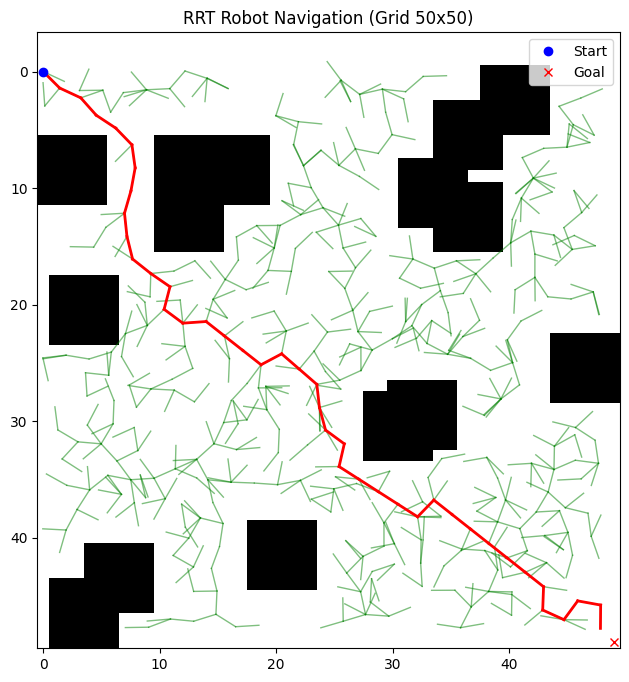

In [9]:
# Parameters
N = 50          # Grid size 50x50
K = 15          # 15 Obstacles
M = 6           # Obstacle size 6x6
ROBOT_SIZE = 2  # Robot size (distance between corners)
START = (0, 0)
GOAL = (N-1, N-1)

# 1. Generate Grid
my_grid = create_grid_with_obstacles(N, K, M)

# Ensure start and goal are not inside obstacles (just a safety check)
my_grid[0:3, 0:3] = 0
my_grid[N-3:N, N-3:N] = 0

# 2. Run RRT
explored_map, node_tree, final_node = rrt_algorithm(my_grid, START, GOAL, num_steps=2000, step_size=2.0, robot_size=ROBOT_SIZE)

# --- Visualization (Matplotlib) ---
plt.figure(figsize=(8, 8))
plt.imshow(my_grid, cmap='Greys', origin='upper')

# Plot the tree edges
for node in node_tree:
    if node.parent:
        plt.plot([node.x, node.parent.x], [node.y, node.parent.y], 'g-', alpha=0.5, linewidth=1)

# Plot the final path if goal reached
if final_node:
    curr = final_node
    while curr:
        if curr.parent:
             plt.plot([curr.x, curr.parent.x], [curr.y, curr.parent.y], 'r-', linewidth=2)
        curr = curr.parent

plt.plot(START[0], START[1], 'bo', label='Start') # Blue dot
plt.plot(GOAL[0], GOAL[1], 'rx', label='Goal')    # Red X
plt.title(f"RRT Robot Navigation (Grid {N}x{N})")
plt.legend()
plt.show()